In [ ]:
#@title Datasets: synthetic + MNIST/fMNIST (çoklu ikili) + CIFAR10 + SVHN + **Paper Synthetic A/B/C**
from pathlib import Path
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_blobs
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10

# SVHN (tfds) kurulum/ithalat
try:
    import tensorflow_datasets as tfds
except Exception:
    !pip -q install tensorflow-datasets
    import tensorflow_datasets as tfds

RNG = np.random.default_rng(42)
OUT = Path('data'); OUT.mkdir(exist_ok=True)

def save_npz(X_train, y_train, X_test, y_test, name):
    p = OUT / f"{name}.npz"
    np.savez_compressed(p, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    print("saved", p, X_train.shape, X_test.shape)

# =========================
# ---------- Synthetic (existing) ----------
# A: Moons
X_all, y_all = make_moons(n_samples=10000, noise=0.30, random_state=0)
idx = RNG.permutation(len(X_all))
tr, te = idx[:1000], idx[1000:2000]
save_npz(X_all[tr], y_all[tr], X_all[te], y_all[te], "synthetic_A_moons_1k_each")
save_npz(X_all, y_all, X_all, y_all, "synthetic_A_moons_full10k")

# B: Circles
Xb, yb = make_circles(n_samples=2000, noise=0.10, factor=0.5, random_state=1)
save_npz(Xb[:1000], yb[:1000], Xb[1000:2000], yb[1000:2000], "synthetic_B_circles_1k_each")

# C: Blobs
Xc, yc = make_blobs(n_samples=2000, centers=[(-1,0),(1,0)], cluster_std=[1.1,1.1], random_state=2)
save_npz(Xc[:1000], yc[:1000], Xc[1000:2000], yc[1000:2000], "synthetic_C_blobs_1k_each")

# =========================
# ---------- Paper Synthetic A/B/C (ADDED) ----------

def _split_balanced(X0, X1, n_train_each=1000, n_test_each=1000, rng=RNG):
    """X0, X1: (N0, d) ve (N1, d). Her sınıftan n_train_each + n_test_each ayırır."""
    assert len(X0) >= n_train_each + n_test_each and len(X1) >= n_train_each + n_test_each
    i0 = rng.permutation(len(X0))
    i1 = rng.permutation(len(X1))
    X0_tr = X0[i0[:n_train_each]]; X0_te = X0[i0[n_train_each:n_train_each+n_test_each]]
    X1_tr = X1[i1[:n_train_each]]; X1_te = X1[i1[n_train_each:n_train_each+n_test_each]]
    Xtr = np.vstack([X0_tr, X1_tr]); ytr = np.hstack([np.zeros(len(X0_tr), dtype=np.int64), np.ones(len(X1_tr), dtype=np.int64)])
    Xte = np.vstack([X0_te, X1_te]); yte = np.hstack([np.zeros(len(X0_te), dtype=np.int64), np.ones(len(X1_te), dtype=np.int64)])
    # karıştır
    p_tr = rng.permutation(len(Xtr)); p_te = rng.permutation(len(Xte))
    return Xtr[p_tr], ytr[p_tr], Xte[p_te], yte[p_te]

# --- Paper Synthetic A: "Sinusoidal bands" (2D) ---
# İki sınıf: y = sin(x) + offset ve y = sin(x) - offset çevresinde gürültülü şeritler.
def make_sin_bands(n_each=4000, x_range=(-np.pi, np.pi), offset=0.9, noise=0.15, rng=RNG):
    xs0 = rng.uniform(x_range[0], x_range[1], size=n_each)
    xs1 = rng.uniform(x_range[0], x_range[1], size=n_each)
    y0 = np.sin(xs0) - offset + rng.normal(0, noise, size=n_each)
    y1 = np.sin(xs1) + offset + rng.normal(0, noise, size=n_each)
    X0 = np.stack([xs0, y0], axis=1)
    X1 = np.stack([xs1, y1], axis=1)
    return X0, X1

X0, X1 = make_sin_bands(n_each=4000, offset=0.9, noise=0.12)
Xa_tr, ya_tr, Xa_te, ya_te = _split_balanced(X0, X1, 1000, 1000)
save_npz(Xa_tr, ya_tr, Xa_te, ya_te, "paper_syn_A_sin_bands_1k_each")

# --- Paper Synthetic B: "Two spirals" (2D, topolojik dolaşıklık) ---
def make_two_spirals(n_each=4000, noise=0.5, turns=3, rng=RNG):
    # klasik çift-spiral: r = a*theta
    theta = rng.uniform(0.0, turns * np.pi, size=n_each)
    a = 0.5
    r = a * theta
    x0 = r * np.cos(theta) + rng.normal(0, noise, size=n_each)
    y0 = r * np.sin(theta) + rng.normal(0, noise, size=n_each)
    # ikinci spiral π faz kaydır
    theta2 = theta + np.pi
    r2 = a * theta2
    x1 = r2 * np.cos(theta2) + rng.normal(0, noise, size=n_each)
    y1 = r2 * np.sin(theta2) + rng.normal(0, noise, size=n_each)
    X0 = np.stack([x0, y0], axis=1)
    X1 = np.stack([x1, y1], axis=1)
    return X0, X1

X0, X1 = make_two_spirals(n_each=4000, noise=0.35, turns=3.5)
Xb_tr, yb_tr, Xb_te, yb_te = _split_balanced(X0, X1, 1000, 1000)
save_npz(Xb_tr, yb_tr, Xb_te, yb_te, "paper_syn_B_two_spirals_1k_each")

# --- Paper Synthetic C: "Sine surface vs plane" (3D, sinüs yüzeyi ile düzlemin kesişmesi) ---
# Sınıf-0: z ≈ 0 düzlemi çevresinde gürültülü nokta bulutu
# Sınıf-1: z ≈ sin(x) + 0.5*sin(y) yüzeyi çevresinde gürültülü nokta bulutu
def make_sine_surface_vs_plane(n_each=6000, xy_range=(-2*np.pi, 2*np.pi), noise_xy=0.05, noise_z=0.12, rng=RNG):
    # Plane (class 0)
    x0 = rng.uniform(xy_range[0], xy_range[1], size=n_each)
    y0 = rng.uniform(xy_range[0], xy_range[1], size=n_each)
    z0 = rng.normal(0, noise_z, size=n_each)  # z ~ 0
    X0 = np.stack([x0 + rng.normal(0, noise_xy, size=n_each),
                   y0 + rng.normal(0, noise_xy, size=n_each),
                   z0], axis=1)
    # Sine surface (class 1)
    x1 = rng.uniform(xy_range[0], xy_range[1], size=n_each)
    y1 = rng.uniform(xy_range[0], xy_range[1], size=n_each)
    z1_mean = np.sin(x1) + 0.5*np.sin(y1)
    z1 = z1_mean + rng.normal(0, noise_z, size=n_each)
    X1 = np.stack([x1 + rng.normal(0, noise_xy, size=n_each),
                   y1 + rng.normal(0, noise_xy, size=n_each),
                   z1], axis=1)
    return X0, X1

X0, X1 = make_sine_surface_vs_plane(n_each=6000, xy_range=(-3.0, 3.0), noise_xy=0.03, noise_z=0.08)
Xc_tr, yc_tr, Xc_te, yc_te = _split_balanced(X0, X1, 1000, 1000)
save_npz(Xc_tr, yc_tr, Xc_te, yc_te, "paper_syn_C_sine_surface_vs_plane_1k_each")

# =========================
# ---------- Helpers ----------
def subset_digits_flat(x, y, pos, neg):
    sel = np.where((y==pos)|(y==neg))[0]
    X = x[sel].astype('float32')/255.0
    yb = (y[sel]==pos).astype('int64')
    X = X.reshape((X.shape[0], -1))
    return X, yb

def _tfds_to_numpy(ds, take=None):
    Xs, ys = [], []
    for i, ex in enumerate(tfds.as_numpy(ds)):
        if (take is not None) and (i>=take): break
        Xs.append(ex['image'])
        ys.append(ex['label'])
    X = np.stack(Xs).astype('float32')/255.0
    y = np.array(ys).astype('int64')
    return X, y

def subset_pair(X, y, a, b):
    m = (y==a)|(y==b)
    X = X[m]; y = y[m]
    yb = (y==a).astype('int64')
    return X.reshape((X.shape[0], -1)), yb

# =========================
# ---------- MNIST (çoklu ikili) ----------
(Xtr, ytr), (Xte, yte) = mnist.load_data()
mnist_pairs = [
    (1,7,'mnist_1v7'),
    (6,8,'mnist_6v8'),
    (0,8,'mnist_0v8'),
    (2,7,'mnist_2v7'),
    (3,5,'mnist_3v5'),
    (4,9,'mnist_4v9'),
]
for a,b,name in mnist_pairs:
    Xtr2, ytr2 = subset_digits_flat(Xtr, ytr, a, b)
    Xte2, yte2 = subset_digits_flat(Xte, yte, a, b)
    save_npz(Xtr2, ytr2, Xte2, yte2, name)

# ---------- Fashion-MNIST (çoklu ikili) ----------
(Xtr, ytr), (Xte, yte) = fashion_mnist.load_data()
fmnist_pairs = [
    (5,9,'fmnist_sandal_v_boot'),
    (6,4,'fmnist_shirt_v_coat'),
    (0,6,'fmnist_tshirt_v_shirt'),
]
for a,b,name in fmnist_pairs:
    Xtr2, ytr2 = subset_digits_flat(Xtr, ytr, a, b)
    Xte2, yte2 = subset_digits_flat(Xte, yte, a, b)
    save_npz(Xtr2, ytr2, Xte2, yte2, name)

# ---------- CIFAR-10 (iki ikili) ----------
# labels: 0=airplane,1=automobile,2=bird,3=cat,4=deer,5=dog,6=frog,7=horse,8=ship,9=truck
(Xtr, ytr), (Xte, yte) = cifar10.load_data()
ytr = ytr.ravel().astype('int64'); yte = yte.ravel().astype('int64')
# cat(3) vs dog(5)
Xtr2, ytr2 = subset_pair(Xtr, ytr, 3, 5)
Xte2, yte2 = subset_pair(Xte, yte, 3, 5)
save_npz(Xtr2, ytr2, Xte2, yte2, "cifar10_cat_v_dog")
# automobile(1) vs truck(9)
Xtr2, ytr2 = subset_pair(Xtr, ytr, 1, 9)
Xte2, yte2 = subset_pair(Xte, yte, 1, 9)
save_npz(Xtr2, ytr2, Xte2, yte2, "cifar10_car_v_truck")

# ---------- SVHN (iki ikili) ----------
svhn_train = tfds.load('svhn_cropped', split='train', shuffle_files=False, try_gcs=True)
svhn_test  = tfds.load('svhn_cropped', split='test',  shuffle_files=False, try_gcs=True)
Xtr, ytr = _tfds_to_numpy(svhn_train)  # büyükse ileride örnekleme ekleyebiliriz
Xte, yte = _tfds_to_numpy(svhn_test)
# 1 vs 7
Xtr2, ytr2 = subset_pair(Xtr, ytr, 1, 7)
Xte2, yte2 = subset_pair(Xte, yte, 1, 7)
save_npz(Xtr2, ytr2, Xte2, yte2, "svhn_1v7")
# 3 vs 8
Xtr2, ytr2 = subset_pair(Xtr, ytr, 3, 8)
Xte2, yte2 = subset_pair(Xte, yte, 3, 8)
save_npz(Xtr2, ytr2, Xte2, yte2, "svhn_3v8")


saved data\synthetic_A_moons_1k_each.npz (1000, 2) (1000, 2)
saved data\synthetic_A_moons_full10k.npz (10000, 2) (10000, 2)
saved data\synthetic_B_circles_1k_each.npz (1000, 2) (1000, 2)
saved data\synthetic_C_blobs_1k_each.npz (1000, 2) (1000, 2)
saved data\mnist_1v7.npz (13007, 784) (2163, 784)
saved data\mnist_6v8.npz (11769, 784) (1932, 784)
saved data\mnist_0v8.npz (11774, 784) (1954, 784)
saved data\mnist_2v7.npz (12223, 784) (2060, 784)
saved data\mnist_3v5.npz (11552, 784) (1902, 784)
saved data\mnist_4v9.npz (11791, 784) (1991, 784)
saved data\fmnist_sandal_v_boot.npz (12000, 784) (2000, 784)
saved data\fmnist_shirt_v_coat.npz (12000, 784) (2000, 784)
saved data\fmnist_tshirt_v_shirt.npz (12000, 784) (2000, 784)
saved data\cifar10_cat_v_dog.npz (10000, 3072) (2000, 3072)


saved data\cifar10_car_v_truck.npz (10000, 3072) (2000, 3072)


Dl Completed...:  67%|██████▋   | 2/3 [03:17<01:38, 98.62s/ url]


OSError: [Errno 28] No space left on device

In [ ]:
#@title Görselleştirme: data/*.npz içindeki TÜM datasetler için otomatik çizim
import os, math, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
MAX_PLOT_POINTS = 3000     # scatter için üst sınır (performans/okunurluk)
IMG_PER_CLASS = 8          # pano başına sınıf başına örnek
SEED = 123
RNG = np.random.default_rng(SEED)

# Yalnızca belirli datasetleri çizmek istersen isim (npz adı) ekle:
INCLUDE_ONLY = None  # örn: ["paper_syn_A_sin_bands_1k_each", "mnist_1v7"]

def _class_counts(y):
    vals, cnts = np.unique(y, return_counts=True)
    return dict(zip(vals.tolist(), cnts.tolist()))

def _subsample(X, y, max_n=MAX_PLOT_POINTS):
    n = len(X)
    if n <= max_n: 
        return X, y
    idx = RNG.permutation(n)[:max_n]
    return X[idx], y[idx]

def _grid_dims(n_panels):
    cols = min(8, n_panels)
    rows = math.ceil(n_panels / cols)
    return rows, cols

def _guess_image_shape(d):
    # Yaygın düzleştirilmiş görüntü boyutları için heuristik:
    if d == 28*28:          # MNIST / fMNIST
        return (28, 28, 1)
    if d == 32*32*3:        # CIFAR10 / SVHN
        return (32, 32, 3)
    if d == 32*32:          # muhtemel 32x32 grayscale
        return (32, 32, 1)
    return None

def _plot_images_grid(X, y, img_shape, title="", img_per_class=IMG_PER_CLASS):
    classes = sorted(np.unique(y).tolist())
    n_panels = len(classes) * img_per_class
    rows, cols = _grid_dims(n_panels)
    plt.figure(figsize=(cols*1.4, rows*1.4))
    k = 1
    for c in classes:
        idx = np.where(y==c)[0]
        if len(idx)==0: 
            continue
        take = min(img_per_class, len(idx))
        pick = RNG.choice(idx, size=take, replace=False)
        for i in pick:
            plt.subplot(rows, cols, k)
            img = X[i].reshape(img_shape)
            if img_shape[2] == 1:
                plt.imshow(img.squeeze(), cmap="gray")
            else:
                plt.imshow(img)
            plt.axis("off")
            plt.title(f"y={c}", fontsize=8)
            k += 1
    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()

def _scatter2d(X, y, title=""):
    Xs, ys = _subsample(X, y)
    plt.figure(figsize=(5.2, 4.6))
    plt.scatter(Xs[:,0], Xs[:,1], c=ys, s=8, alpha=0.8)
    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

def _scatter3d(X, y, title=""):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    Xs, ys = _subsample(X, y)
    fig = plt.figure(figsize=(6, 5.2))
    ax = fig.add_subplot(111, projection="3d")
    p = ax.scatter(Xs[:,0], Xs[:,1], Xs[:,2], c=ys, s=8, alpha=0.85)
    ax.set_title(title)
    ax.set_xlabel("x1"); ax.set_ylabel("x2"); ax.set_zlabel("x3")
    plt.tight_layout(); plt.show()

def _pca2(X, n_components=2):
    from sklearn.decomposition import PCA
    return PCA(n_components=n_components).fit_transform(X)

def visualize_npz_dataset(npz_path: Path):
    name = npz_path.stem
    data = np.load(npz_path)
    Xtr, ytr = data["X_train"], data["y_train"]
    d = Xtr.shape[1] if Xtr.ndim == 2 else (np.prod(Xtr.shape[1:]) if Xtr.ndim>2 else 1)
    if Xtr.ndim > 2:  # güvenli tarafta ol
        Xtr = Xtr.reshape((Xtr.shape[0], -1))
        d = Xtr.shape[1]

    # Özet bilgi
    print(f"\n=== {name} ===")
    print(f"train: {Xtr.shape}, classes: {sorted(np.unique(ytr).tolist())}, counts: {_class_counts(ytr)}")
    
    # Görsel karar ağacı
    img_shape = _guess_image_shape(d)
    if d == 2:
        _scatter2d(Xtr, ytr, title=f"{name} (2D)")
    elif d == 3:
        _scatter3d(Xtr, ytr, title=f"{name} (3D)")
    elif img_shape is not None:
        _plot_images_grid(Xtr, ytr, img_shape, title=f"{name} (images)")
    else:
        # Genel durum: PCA(2D) + scatter
        Z = _pca2(_subsample(Xtr, ytr)[0], n_components=2)
        _, ysub = _subsample(ytr.reshape(-1,1), ytr)[0].ravel(), _subsample(ytr, ytr)[1]  # aynı RNG ile çağrıldığı varsayımı
        plt.figure(figsize=(5.2,4.6))
        plt.scatter(Z[:,0], Z[:,1], c=ysub, s=8, alpha=0.8)
        plt.title(f"{name} (PCA→2D)")
        plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# ==== Ana akış: tüm .npz dosyalarını çiz ====
npz_files = sorted([p for p in DATA_DIR.glob("*.npz")])
if INCLUDE_ONLY is not None:
    npz_files = [p for p in npz_files if p.stem in INCLUDE_ONLY]

if not npz_files:
    print("data/ içinde .npz bulunamadı. Önce veri hücresini çalıştır.")
else:
    for p in npz_files:
        try:
            visualize_npz_dataset(p)
        except Exception as e:
            print(f"[WARN] {p.name} çizilemedi: {e}")


In [ ]:
#@title MLP factory (ReLU, RMSprop 1e-3, BCE) — NPZ'den otomatik input_dim
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_mlp(input_dim, width='narrow', depth=5,
              hidden_activation='relu',
              out_activation='sigmoid',
              optimizer='rmsprop',
              learning_rate=1e-3):
    """
    width: ['narrow','wide','bottleneck']
    depth: narrow/wide için katman sayısı; bottleneck için {5,11}
    """
    assert width in ['narrow','wide','bottleneck'], "width ∈ {'narrow','wide','bottleneck'} olmalı"

    inputs = keras.Input(shape=(input_dim,))
    x = inputs

    if width == 'bottleneck':
        if depth == 5:
            units = [50,50,25,50,50]
        elif depth == 11:
            units = [50,50,50,50,50,25,50,50,50,50,50]
        else:
            raise ValueError("bottleneck için depth {5,11} olmalı")
        for u in units:
            x = layers.Dense(u, activation=hidden_activation)(x)
    else:
        hidden_units = 25 if width=='narrow' else 50
        for _ in range(depth):
            x = layers.Dense(hidden_units, activation=hidden_activation)(x)

    outputs = layers.Dense(1, activation=out_activation)(x)
    model = keras.Model(inputs, outputs)

    # optimizer seçimi
    opt = optimizer.lower()
    if opt == 'rmsprop':
        opt_obj = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif opt == 'adam':
        opt_obj = keras.optimizers.Adam(learning_rate=learning_rate)
    elif opt == 'sgd':
        opt_obj = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    else:
        raise ValueError("optimizer ∈ {'rmsprop','adam','sgd'}")

    model.compile(optimizer=opt_obj, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def _npz_input_dim(npz_path):
    """
    data/<name>.npz dosyasını okuyup X_train'in sütun sayısını döndürür.
    (Sentetik 2D/3D setler veya önceden flatten edilmiş görüntülerle uyumlu.)
    """
    with np.load(npz_path) as data:
        Xtr = data['X_train']
    Xtr = Xtr.reshape((Xtr.shape[0], -1))
    return Xtr.shape[1]

def build_mlp_for_npz(npz_path, width='narrow', depth=5,
                      hidden_activation='relu',
                      out_activation='sigmoid',
                      optimizer='rmsprop',
                      learning_rate=1e-3):
    input_dim = _npz_input_dim(npz_path)
    return build_mlp(input_dim,
                     width=width, depth=depth,
                     hidden_activation=hidden_activation,
                     out_activation=out_activation,
                     optimizer=optimizer,
                     learning_rate=learning_rate)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │            75 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701 (10.55 KB)

 Trainable params: 2,701 (10.55 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- kısa smoke test (yorumdan çıkarıp herhangi bir NPZ ile deneyebilirsin) ---
m = build_mlp_for_npz("data/paper_syn_A_sin_bands_1k_each.npz", width='bottleneck', depth=5)
m.summary()


In [ ]:
#@title FIX+EXT: Keras 3 uyumlu embedding çıkarımı + standardizasyon + run_cycle
from pathlib import Path
import json, glob
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

EMB_DIR = Path("embeddings"); EMB_DIR.mkdir(exist_ok=True, parents=True)
CKPT_DIR = Path("checkpoints"); CKPT_DIR.mkdir(exist_ok=True, parents=True)
LOGS_DIR = Path("logs"); LOGS_DIR.mkdir(exist_ok=True, parents=True)

def _standardize_train_test(Xtr, Xte):
    mu = Xtr.mean(axis=0, keepdims=True)
    sd = Xtr.std(axis=0, keepdims=True) + 1e-8
    return (Xtr - mu)/sd, (Xte - mu)/sd, mu.astype(np.float32), sd.astype(np.float32)

def _ensure_float32(*arrays):
    return [a.astype(np.float32, copy=False) for a in arrays]

def run_one(dataset_npz, width, depth, epochs=50, batch_size=128, seed=0, standardize=True, save_meta=True):
    """
    dataset_npz: Path to .npz with keys (X_train,y_train,X_test,y_test)
    Returns: (test_acc: float, base: str, layer_names: list[str])
    """
    d = np.load(dataset_npz)
    Xtr, ytr, Xte, yte = d['X_train'], d['y_train'], d['X_test'], d['y_test']
    # Keras beklentisi için dtype ve şekil
    Xtr, Xte = _ensure_float32(Xtr, Xte)
    ytr = ytr.astype(np.int32, copy=False)
    yte = yte.astype(np.int32, copy=False)

    if standardize:
        Xtr, Xte, mu, sd = _standardize_train_test(Xtr, Xte)
    else:
        mu = np.zeros((1, Xtr.shape[1]), dtype=np.float32)
        sd = np.ones((1, Xtr.shape[1]), dtype=np.float32)

    input_dim = Xtr.shape[1]
    tf.keras.utils.set_random_seed(seed)

    # build_mlp kullanıcı hücresinde tanımlı (binary çıktı varsayımı)
    model = build_mlp(input_dim, width=width, depth=depth)
    _ = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=epochs, batch_size=batch_size, verbose=0)
    te_loss, te_acc = model.evaluate(Xte, yte, verbose=0)

    # --- Keras 3 uyumlu ara katman çıktıları ---
    dense_layers = [lyr for lyr in model.layers if isinstance(lyr, layers.Dense)]
    layer_names = [lyr.name for lyr in dense_layers]
    inter_model = keras.Model(inputs=model.input, outputs=[lyr.output for lyr in dense_layers])
    emb_list = inter_model.predict(Xte, batch_size=1024, verbose=0)  # list[np.ndarray]

    # Kaydetme
    base = Path(dataset_npz).stem + f"__w{width}_d{depth}_seed{seed}"
    out_dir = (EMB_DIR / base); out_dir.mkdir(parents=True, exist_ok=True)
    for name, E in zip(layer_names, emb_list):
        np.save(out_dir / f"{name}.npy", E)
    np.save(out_dir / "y_test.npy", yte)
    np.save(out_dir / "X_test.npy", Xte)
    np.save(out_dir / "mu.npy", mu)  # standardizasyon istatistikleri
    np.save(out_dir / "sd.npy", sd)

    # Model checkpoint
    model.save(CKPT_DIR / f"{base}.keras")

    # Meta/Log
    if save_meta:
        meta = {
            "dataset": str(dataset_npz),
            "width": int(width),
            "depth": int(depth),
            "epochs": int(epochs),
            "batch_size": int(batch_size),
            "seed": int(seed),
            "standardize": bool(standardize),
            "test_acc": float(te_acc),
            "layers": layer_names,
            "embedding_dir": str(out_dir),
            "checkpoint": str(CKPT_DIR / f"{base}.keras"),
        }
        with open(LOGS_DIR / f"{base}.json", "w", encoding="utf-8") as f:
            json.dump(meta, f, ensure_ascii=False, indent=2)

    return float(te_acc), base, layer_names

# --------------------------------------------------------------------
# Yardımcı: dataset bulucu (pattern ile)
def find_datasets(patterns=("data/*.npz",), include_only=None, exclude_substr=None):
    """
    patterns: glob desenleri tuple/list
    include_only: None veya substring listesi (sadece bunları içerenleri al)
    exclude_substr: None veya substring listesi (bunları içerenleri hariç tut)
    """
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    files = sorted(set(files))
    if include_only:
        files = [f for f in files if any(s in f for s in include_only)]
    if exclude_substr:
        files = [f for f in files if not any(s in f for s in exclude_substr)]
    return files

# --------------------------------------------------------------------
# Toplu çalıştırma (cycle)
def run_cycle(widths=(64,128), depths=(3,5), seeds=(0,), epochs=50, batch_size=128,
              patterns=("data/*.npz",),
              include_only=None,  # örn: ["paper_syn_", "mnist_"]
              exclude_substr=None,  # örn: ["full10k"] gibi ağır dosyaları dışla
              standardize=True):
    """
    Örnek:
    run_cycle(widths=(64,), depths=(5,), seeds=(0,1,2),
              include_only=["paper_syn_", "mnist_", "cifar10_car_v_truck"])
    """
    ds_list = find_datasets(patterns, include_only=include_only, exclude_substr=exclude_substr)
    results = []
    for ds in ds_list:
        for w in widths:
            for d in depths:
                for s in seeds:
                    acc, base, layers = run_one(ds, w, d, epochs=epochs, batch_size=batch_size,
                                                seed=s, standardize=standardize, save_meta=True)
                    results.append((ds, w, d, s, acc, base))
                    print(f"[OK] {base}  acc={acc:.4f}")
    # CSV dök
    import csv
    csv_path = LOGS_DIR / "run_cycle_results.csv"
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        wtr = csv.writer(f)
        wtr.writerow(["dataset","width","depth","seed","test_acc","run_id"])
        for (ds, w, d, s, acc, base) in results:
            wtr.writerow([ds, w, d, s, f"{acc:.6f}", base])
    print("Saved:", csv_path)
    return results


In [ ]:
# --- PAPER SYNTHETICS (A/B/C) ---
run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=20, batch_size=256, include_only=["paper_syn_A_sin_bands_1k_each"])

run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=20, batch_size=256, include_only=["paper_syn_B_two_spirals_1k_each"])

run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=20, batch_size=256, include_only=["paper_syn_C_sine_surface_vs_plane_1k_each"])


In [ ]:
# --- MNIST (çoklu ikili) ---
run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=15, batch_size=256, include_only=["mnist_1v7"])

run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=15, batch_size=256, include_only=["mnist_6v8"])

run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=15, batch_size=256, include_only=["mnist_0v8","mnist_2v7","mnist_3v5","mnist_4v9"])


In [ ]:
# --- Fashion-MNIST (çoklu ikili) ---
run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=15, batch_size=256, include_only=["fmnist_sandal_v_boot"])

run_cycle(widths=(64,), depths=(3,), seeds=(0,),
          epochs=15, batch_size=256, include_only=["fmnist_shirt_v_coat","fmnist_tshirt_v_shirt"])


In [ ]:
# --- CIFAR-10 (iki ikili) ---
run_cycle(widths=(128,), depths=(5,), seeds=(0,),
          epochs=20, batch_size=256, include_only=["cifar10_car_v_truck"])

run_cycle(widths=(128,), depths=(5,), seeds=(0,),
          epochs=20, batch_size=256, include_only=["cifar10_cat_v_dog"])


In [ ]:
# --- SVHN (iki ikili) ---
# Not: SVHN büyük; yine de tek seed + 20 epoch kullanıyoruz.
run_cycle(widths=(128,), depths=(5,), seeds=(0,),
          epochs=20, batch_size=512, include_only=["svhn_1v7"])

run_cycle(widths=(128,), depths=(5,), seeds=(0,),
          epochs=20, batch_size=512, include_only=["svhn_3v8"])


In [ ]:
import pandas as pd, json, glob, numpy as np

# 1) Son koşular tablosu
df = pd.read_csv("logs/run_cycle_results.csv")
display(df.tail(12))

# 2) ρ_k – Accuracy (varsa rho'ları birleştir)
# Elinde rho'lar başka CSV'de ise oradan merge et; şimdilik sadece test_acc dağılımı:
scatter_rho_vs_acc(df, by="dataset")  # rho kolonu mevcut dosyanda varsa çizilecek

# 3) Örnek bir koşunun katman trendleri
# Son koşunun run_id’sinden embedding klasörü:
run_id = df.iloc[-1]["run_id"]
emb_dir = Path("embeddings")/run_id
# Bu kısmı senin Ric_l ve g_l üretim fonksiyonlarına bağlı; örnek çağrılar:
# Ric_list = compute_total_forman_ricci_over_layers(emb_dir, k=15)
# g_list   = compute_total_geodesic_over_layers(emb_dir, k=15)
# plot_trends_over_layers(Ric_list, g_list)


In [ ]:
#@title Ricci metrics (fast): ignore last layer, sampling, giant component [UPDATED]
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path, connected_components
from scipy.stats import pearsonr
from pathlib import Path
import re

def _bin_adjacency(A):
    B = (A > 0).astype(np.int8).tocsr()
    return B.maximum(B.T)

def _largest_component_mask(B):
    ncomp, labels = connected_components(csgraph=B, directed=False, return_labels=True)
    if ncomp == 1:
        return np.ones(B.shape[0], dtype=bool), 1.0
    counts = np.bincount(labels)
    giant = np.argmax(counts)
    mask = (labels == giant)
    ratio = counts[giant] / B.shape[0]
    return mask, ratio

def _forman_ricci_total(B):
    deg = np.ravel(B.sum(axis=1)).astype(np.int64)
    rows, cols = B.nonzero()
    mask = rows < cols
    ri = rows[mask]; rj = cols[mask]
    return int(np.sum(4 - deg[ri] - deg[rj]))

def layerwise_global_metrics_fast(
    emb_dir: Path,
    layer_names,
    k_values,
    ignore_last_layer: bool = True,
    sample_size: int | None = None,
    min_component_ratio: float = 0.99,
    rng_seed: int = 0,
    return_connectivity: bool = True,
):
    """
    Her k için:
      - Ric_l toplamı (Forman) ve g_l toplam geodezikten r = corr(eta_l, Ric_l) ve z hesaplar.
      - İsteğe bağlı: connectivity ısı haritası için (k,l) bazlı giant component ratio döndürür.
    """
    use_layers = layer_names[:-1] if ignore_last_layer and len(layer_names) > 1 else layer_names[:]
    if len(use_layers) < 2:
        return [(k, np.nan, np.nan, len(use_layers), False) for k in k_values], None

    y = np.load(emb_dir / "y_test.npy")
    n_total = y.shape[0]
    rng = np.random.default_rng(rng_seed)

    # örnekleme (node subset)
    if sample_size is not None and sample_size < n_total:
        idx = np.sort(rng.choice(n_total, size=sample_size, replace=False))
    else:
        idx = np.arange(n_total)

    results = []
    conn_map = {}  # k -> [ratio per layer]
    for k in k_values:
        Ric, gvals = [], []
        valid = True
        ratios = []

        for lname in use_layers:
            Z = np.load(emb_dir / f"{lname}.npy")[idx]  # (m, d_l)
            A = kneighbors_graph(Z, n_neighbors=k, mode='distance', include_self=False, n_jobs=-1)
            B = _bin_adjacency(A)

            # dev bileşen toleransı
            mask, ratio = _largest_component_mask(B)
            ratios.append(float(ratio))
            if ratio < min_component_ratio:
                valid = False
                # devam etmeden bu k'yı invalid işaretliyoruz
                break

            if not mask.all():
                sel = np.where(mask)[0]
                B = B[sel][:, sel]

            # Ricci toplamı (Forman)
            ric_total = _forman_ricci_total(B)
            Ric.append(float(ric_total))

            # geodezik toplamı (unweighted BFS)
            D = shortest_path(B, directed=False, unweighted=True)
            if np.isinf(D).any():
                valid = False
                break
            gvals.append(float(np.sum(D)))

        if return_connectivity:
            conn_map[k] = ratios if len(ratios)==len(use_layers) else [np.nan]*len(use_layers)

        if not valid:
            results.append((k, np.nan, np.nan, len(use_layers), False))
            continue

        Ric = np.asarray(Ric, dtype=float)
        gvals = np.asarray(gvals, dtype=float)
        eta = gvals[1:] - gvals[:-1]

        # sabit vektörler NaN üretmesin diye kontrol
        if np.allclose(eta, eta[0]) or np.allclose(Ric[:-1], Ric[:-1][0]):
            results.append((k, np.nan, np.nan, len(use_layers), False))
            continue

        r, _ = pearsonr(eta, Ric[:-1])
        # Fisher z: küçük L'de dikkat
        denom = max(len(use_layers) - 4, 1)
        z = np.arctanh(np.clip(r, -0.999999, 0.999999)) / np.sqrt(denom)
        results.append((k, float(r), float(z), len(use_layers), True))

    return results, conn_map if return_connectivity else None


def _infer_dataset_mode_from_runid(run_id: str) -> str:
    """
    run_id'dan sentetik/real ipucu çıkar.
    - 'paper_syn', 'synthetic_' gibi önekler → 'synthetic'
    - aksi → 'real'
    """
    rid = run_id.lower()
    if re.search(r"(paper_syn|synthetic_|syn_|_syn_|moons|spiral|circle|blobs)", rid):
        return "synthetic"
    return "real"


def auto_k_sweep_fast(
    run_id,
    layer_names,
    mode: str | None = None,
    sample_size=None,
    min_component_ratio=0.99,
    rng_seed=0,
    return_connectivity: bool = True,
):
    """
    mode=None ise run_id'a bakarak 'synthetic'/'real' belirlenir.
    - synthetic: daha küçük k'ler de denenir (küçük N ve “daha kıvrımlı” graf yapıları için).
    - real: daha geniş k ızgarası.
    """
    if mode is None:
        mode = _infer_dataset_mode_from_runid(run_id)

    if mode == 'synthetic':
        k_values = [4,5,6,7,9,10,12,15,18,20,30,50,90]
    else:
        k_values = [10,20,30,50,90,120,150,200,250,350]

    emb_dir = Path("embeddings") / run_id
    res, conn_map = layerwise_global_metrics_fast(
        emb_dir, layer_names, k_values,
        ignore_last_layer=True,            # <-- kritik
        sample_size=sample_size,           # örn. 800
        min_component_ratio=min_component_ratio,
        rng_seed=rng_seed,
        return_connectivity=return_connectivity,
    )
    # en negatif r en başa
    good = [r for r in res if r[-1] and not np.isnan(r[1])]
    best = sorted(good, key=lambda x: x[1])[0] if good else None
    return res, best, k_values, conn_map


In [ ]:
# id1: run_id, ln1: layer_names listesi
res, best, ks, conn = auto_k_sweep_fast(id1, ln1, mode='synthetic', sample_size=None, rng_seed=0)

print("k, rho, z, L, connected")
for t in res:
    print(t)
print("BEST:", best)

# (opsiyonel) bağlı bileşen ısı haritası: conn[k] -> her katman için ratio
# connectivity_heatmap fonksiyonunu daha önce verdiğim hücreden çağırabilirsin:
connectivity_heatmap(conn)


k, rho, z, L, connected
(6, -0.5748606682089931, -0.6547525640061287, 5, True)
(7, -0.7657488110222227, -1.0099680690743023, 5, True)
(9, -0.74154882287032, -0.9539116590800517, 5, True)
(10, -0.8266083087887217, -1.1773314983558978, 5, True)
(15, -0.676123124127074, -0.8219376552977097, 5, True)
(18, 0.21027980804542504, 0.2134640814266939, 5, True)
(20, -0.19907300390085092, -0.20176711926627044, 5, True)
(30, -0.4392883141223804, -0.4713485997985011, 5, True)
(50, -0.5274937798871281, -0.5866663539216386, 5, True)
(90, -0.016261924588494247, -0.016263358305678755, 5, True)
BEST: (10, -0.8266083087887217, -1.1773314983558978, 5, True)


In [ ]:
#@title ProgressBoard yardımcıları (reset-safe, grid-aware)
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional, Iterable
import time, pandas as pd, numpy as np
from IPython.display import clear_output, display
import math
from itertools import product

@dataclass
class ProgressBoard:
    columns: List[str]
    title: str = "Progress"
    rows: List[Dict[str, Any]] = field(default_factory=list)
    total: Optional[int] = None
    t0: float = field(default_factory=time.time)
    auto_cols: bool = True            # yeni alanları kolonlara otomatik ekle
    sort_pref: List[str] = field(default_factory=lambda: ["dataset","mode","width","depth","k","seed","elapsed_s"])
    _last_render: float = field(default_factory=lambda: 0.0)
    _render_min_interval: float = 0.2 # saniye; çok hızlı add() spam’ında ekranı yormasın

    # --- API ---
    def set_total(self, total: int):
        self.total = int(total)
        self.render(force=True)

    def bump_total(self, delta: int):
        self.total = (self.total or 0) + int(delta)
        self.render(force=True)

    def set_total_from_grid(self,
                            datasets: Iterable[str],
                            widths: Iterable[Any],
                            depths: Iterable[Any],
                            seeds: Iterable[int],
                            ks: Optional[Iterable[int]] = None,
                            repeats: int = 1):
        """
        grid toplam adımı hesaplar:
          |datasets| × |widths| × |depths| × |seeds| × (|ks| veya 1) × repeats
        """
        n = len(list(datasets)) * len(list(widths)) * len(list(depths)) * len(list(seeds))
        n *= (len(list(ks)) if ks is not None else 1)
        n *= int(repeats)
        self.set_total(n)

    def add(self, **kwargs):
        """
        Örn:
        add(dataset="paper_syn_A_sin_bands_1k_each", mode="real", width="narrow", depth=7,
            k=25, seed=0, test_acc=0.912, rho=-0.63, z=-0.71, connected_all_layers=True,
            elapsed_s=123.4, run_id="...") 
        """
        self.rows.append(kwargs)
        self.render()

    # --- İç ---
    def _compute_eta(self, done: int, elapsed: float):
        if not self.total or done == 0: 
            return None
        rate = done / max(elapsed, 1e-9)
        remain = self.total - done
        eta_s = remain / max(rate, 1e-9)
        return eta_s

    def render(self, force: bool=False):
        now = time.time()
        if not force and (now - self._last_render) < self._render_min_interval:
            return
        self._last_render = now

        clear_output(wait=True)

        # DataFrame’e dök
        df = pd.DataFrame(self.rows)

        # kolonları tamamla / yeni metrikleri ekle
        if self.auto_cols and len(df):
            unseen = [c for c in df.columns if c not in self.columns]
            if unseen:
                self.columns += unseen

        # eksik kolonları doldur
        for c in self.columns:
            if c not in df.columns:
                df[c] = np.nan

        # sıralama
        sort_cols = [c for c in self.sort_pref if c in df.columns]
        if sort_cols:
            with pd.option_context('mode.use_inf_as_na', True):
                df = df.sort_values(by=sort_cols, na_position='last', kind="mergesort")

        # sadece tanımlı kolonları göster
        df = df[self.columns]

        # başlık
        print(f"=== {self.title} ===")
        display(df)

        # durum satırı
        done = len(self.rows)
        elapsed = time.time() - self.t0
        if self.total:
            pct = 100.0 * done / max(self.total, 1)
            eta_s = self._compute_eta(done, elapsed)
            eta_str = f" | ETA ~{_fmt_duration(eta_s)}" if eta_s is not None and eta_s < 9e6 else ""
            print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {_fmt_duration(elapsed)}{eta_str}")
        else:
            print(f"[{self.title}] steps={done} | elapsed {_fmt_duration(elapsed)}")

        # küçük özet: dataset bazlı tamamlanan sayılar
        if len(df) and "dataset" in df.columns:
            cnt = df["dataset"].value_counts().sort_index()
            with pd.option_context('display.max_rows', 200, 'display.width', 120):
                print("\nCompleted per dataset:")
                display(cnt.to_frame("done"))

def timed_step(fn, *args, **kwargs):
    t0 = time.time()
    out = fn(*args, **kwargs)
    return out, round(time.time()-t0, 1)

def _fmt_duration(sec: float) -> str:
    if sec is None: return "?"
    sec = float(sec)
    if sec < 60: return f"{sec:.1f}s"
    m, s = divmod(int(round(sec)), 60)
    if m < 60: return f"{m}m{s:02d}s"
    h, m = divmod(m, 60)
    return f"{h}h{m:02d}m"

print("ProgressBoard (grid-aware) loaded.")


ProgressBoard loaded.


In [ ]:
 #@title Grid runner (FAST) + Canlı İlerleme Paneli
from pathlib import Path
import time, pandas as pd, numpy as np
from IPython.display import clear_output, display
from tqdm.auto import tqdm

# 1) Çalıştırılacak dataset listesi
DATASETS = [
  # Sentetik
  ("data/synthetic_A_moons_1k_each.npz", "synthetic"),
  ("data/synthetic_B_circles_1k_each.npz", "synthetic"),
  ("data/synthetic_C_blobs_1k_each.npz", "synthetic"),
  # MNIST/fMNIST (çeşitlendirilmiş)
  ("data/mnist_1v7.npz", "real"),
  ("data/mnist_6v8.npz", "real"),
  ("data/mnist_0v8.npz", "real"),
  ("data/mnist_2v7.npz", "real"),
  ("data/mnist_3v5.npz", "real"),
  ("data/mnist_4v9.npz", "real"),
  ("data/fmnist_sandal_v_boot.npz", "real"),
  ("data/fmnist_shirt_v_coat.npz", "real"),
  ("data/fmnist_tshirt_v_shirt.npz", "real"),
  # CIFAR-10
  ("data/cifar10_cat_v_dog.npz", "real"),
  ("data/cifar10_car_v_truck.npz", "real"),
  # SVHN
  ("data/svhn_1v7.npz", "real"),
  ("data/svhn_3v8.npz", "real"),
]

WIDTHS = ["narrow","wide","bottleneck"]
DEPTHS = [5,11]

def _sample_size_for(mode, ds_name):
    if mode == 'synthetic':
        return None
    # gerçek veriler için hızlı Ricci: dataset'e göre örneklem büyüklüğü
    if ds_name.startswith("cifar10") or ds_name.startswith("svhn"):
        return 1200   # daha büyük, çünkü sınıflar daha kompleks
    else:
        return 800    # mnist/fmnist

summary_rows = []
total = len(DATASETS)*len(WIDTHS)*len(DEPTHS)
i = 0

start_global = time.time()
for ds, mode in DATASETS:
    ds_name = Path(ds).stem
    for w in WIDTHS:
        for d in DEPTHS:
            i += 1
            step_t0 = time.time()
            try:
                acc, run_id, layer_names = run_one(ds, w, d, epochs=60, seed=0)
                ss = _sample_size_for(mode, ds_name)
                res, best = auto_k_sweep_fast(run_id, layer_names, mode=mode,
                                              sample_size=ss, rng_seed=0)
                row = {
                    "dataset": ds_name, "mode": mode,
                    "width": w, "depth": d,
                    "test_acc": float(acc),
                    "best_k": (int(best[0]) if best else None),
                    "rho": (float(best[1]) if best else None) if best else None,
                    "z": (float(best[2]) if best else None) if best else None,
                    "L": (int(best[3]) if best else None) if best else None,
                    "connected_all_layers": (bool(best[-1]) if best else False) if best else False,
                    "run_id": run_id,
                    "elapsed_s": round(time.time()-step_t0, 1)
                }
                summary_rows.append(row)
                status = f"DONE {ds_name:>28} | {w:10s} d={d:>2} | acc={acc:.4f} | best={best} | step={row['elapsed_s']}s"
                print(status)
            except Exception as e:
                row = {
                    "dataset": ds_name, "mode": mode,
                    "width": w, "depth": d,
                    "error": str(e)
                }
                summary_rows.append(row)
                print(f"SKIP {ds_name} {w} d={d} -> {e}")

            # canlı çıktı tablosu
            clear_output(wait=True)
            df_live = pd.DataFrame(summary_rows)
            # sıralama ve gösterim
            order_cols = ["dataset","mode","width","depth","test_acc","best_k","rho","z","connected_all_layers","elapsed_s","run_id","error"]
            for c in order_cols:
                if c not in df_live.columns:
                    df_live[c] = np.nan
            df_live = df_live[order_cols].sort_values(by=["dataset","width","depth","elapsed_s"], na_position='last')
            display(df_live)
            done_pct = 100.0 * i / total
            print(f"[{i}/{total}] {done_pct:.1f}% | total elapsed: {round(time.time()-start_global,1)}s")

# final kaydet
df = pd.DataFrame(summary_rows).sort_values(by=["dataset","width","depth"], na_position='last')
csv_path = Path("ricci_summary.csv"); df.to_csv(csv_path, index=False)
print("Saved ->", csv_path)
df


,dataset,mode,width,depth,test_acc,best_k,rho,z,connected_all_layers,elapsed_s,run_id,error
82,cifar10_car_v_truck,real,bottleneck,5,0.6355,NaN,NaN,NaN,False,23.8,cifar10_car_v_truck__bottleneck_d5_seed0,NaN
83,cifar10_car_v_truck,real,bottleneck,11,0.7200,250.0,-0.377503,-0.150107,True,128.5,cifar10_car_v_truck__bottleneck_d11_seed0,NaN
78,cifar10_car_v_truck,real,narrow,5,0.6910,NaN,NaN,NaN,False,21.7,cifar10_car_v_truck__narrow_d5_seed0,NaN
79,cifar10_car_v_truck,real,narrow,11,0.6835,350.0,-0.556346,-0.237182,True,143.3,cifar10_car_v_truck__narrow_d11_seed0,NaN
80,cifar10_car_v_truck,real,wide,5,0.6610,NaN,NaN,NaN,False,21.6,cifar10_car_v_truck__wide_d5_seed0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17,synthetic_C_blobs_1k_each,synthetic,bottleneck,11,0.8340,10.0,-0.164957,-0.062923,True,45.7,synthetic_C_blobs_1k_each__bottleneck_d11_seed0,NaN
12,synthetic_C_blobs_1k_each,synthetic,narrow,5,0.8300,30.0,-0.981420,-2.334741,True,27.2,synthetic_C_blobs_1k_each__narrow_d5_seed0,NaN
13,synthetic_C_blobs_1k_each,synthetic,narrow,11,0.8230,15.0,-0.691696,-0.321723,True,46.2,synthetic_C_blobs_1k_each__narrow_d11_seed0,NaN
14,synthetic_C_blobs_1k_each,synthetic,wide,5,0.8290,15.0,-0.988824,-2.590764,True,26.7,synthetic_C_blobs_1k_each__wide_d5_seed0,NaN


[96/96] 100.0% | total elapsed: 5987.1s
Saved -> ricci_summary.csv


,dataset,mode,width,depth,test_acc,best_k,rho,z,L,connected_all_layers,run_id,elapsed_s
82,cifar10_car_v_truck,real,bottleneck,5,0.6355,NaN,NaN,NaN,NaN,False,cifar10_car_v_truck__bottleneck_d5_seed0,23.8
83,cifar10_car_v_truck,real,bottleneck,11,0.7200,250.0,-0.377503,-0.150107,11.0,True,cifar10_car_v_truck__bottleneck_d11_seed0,128.5
78,cifar10_car_v_truck,real,narrow,5,0.6910,NaN,NaN,NaN,NaN,False,cifar10_car_v_truck__narrow_d5_seed0,21.7
79,cifar10_car_v_truck,real,narrow,11,0.6835,350.0,-0.556346,-0.237182,11.0,True,cifar10_car_v_truck__narrow_d11_seed0,143.3
80,cifar10_car_v_truck,real,wide,5,0.6610,NaN,NaN,NaN,NaN,False,cifar10_car_v_truck__wide_d5_seed0,21.6
...,...,...,...,...,...,...,...,...,...,...,...,...
17,synthetic_C_blobs_1k_each,synthetic,bottleneck,11,0.8340,10.0,-0.164957,-0.062923,11.0,True,synthetic_C_blobs_1k_each__bottleneck_d11_seed0,45.7
12,synthetic_C_blobs_1k_each,synthetic,narrow,5,0.8300,30.0,-0.981420,-2.334741,5.0,True,synthetic_C_blobs_1k_each__narrow_d5_seed0,27.2
13,synthetic_C_blobs_1k_each,synthetic,narrow,11,0.8230,15.0,-0.691696,-0.321723,11.0,True,synthetic_C_blobs_1k_each__narrow_d11_seed0,46.2
14,synthetic_C_blobs_1k_each,synthetic,wide,5,0.8290,15.0,-0.988824,-2.590764,5.0,True,synthetic_C_blobs_1k_each__wide_d5_seed0,26.7


In [ ]:
#@title 5-seed istikrar analizi (panel, self-contained)
# Guard: ProgressBoard/timed_step tanımlı değilse burada tanımla
try:
    ProgressBoard; timed_step
except NameError:
    from dataclasses import dataclass, field
    from typing import List, Dict, Any, Optional
    import time, pandas as pd, numpy as np
    from IPython.display import clear_output, display
    @dataclass
    class ProgressBoard:
        columns: List[str]
        title: str = "Progress"
        rows: List[Dict[str, Any]] = field(default_factory=list)
        total: Optional[int] = None
        t0: float = field(default_factory=time.time)
        def add(self, **kwargs):
            self.rows.append(kwargs); self.render()
        def render(self):
            clear_output(wait=True)
            df = pd.DataFrame(self.rows)
            for c in self.columns:
                if c not in df.columns: df[c] = np.nan
            df = df[self.columns]
            sort_cols = [c for c in ["dataset","width","depth","seed","elapsed_s"] if c in df.columns]
            if sort_cols: df = df.sort_values(by=sort_cols, na_position='last')
            display(df)
            done = len(self.rows)
            if self.total:
                pct = 100.0 * done / self.total
                elapsed = time.time() - self.t0
                print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {elapsed:.1f}s")
            else:
                print(f"[{self.title}] steps={done} | elapsed {time.time()-self.t0:.1f}s")
    def timed_step(fn, *args, **kwargs):
        t0 = time.time(); out = fn(*args, **kwargs); return out, round(time.time()-t0, 1)

from pathlib import Path
import numpy as np, pandas as pd, time

targets = [
  ("data/synthetic_A_moons_1k_each.npz","synthetic","narrow",5),
  ("data/mnist_1v7.npz","real","wide",5),
  ("data/fmnist_shirt_v_coat.npz","real","wide",11),
  ("data/svhn_3v8.npz","real","wide",11),
  ("data/cifar10_cat_v_dog.npz","real","wide",11),
]

board = ProgressBoard(
    columns=["dataset","mode","width","depth","seed","test_acc","best_k","rho","z","elapsed_s","run_id"],
    title="Stability (5 seeds)", total=len(targets)*5
)

rows=[]
for ds,mode,w,d in targets:
    for seed in range(5):
        t0=time.time()
        acc, run_id, lnames = run_one(ds, w, d, epochs=60, seed=seed)
        ss = None if mode=='synthetic' else (1200 if Path(ds).stem.startswith(("cifar10","svhn")) else 800)
        ((res,best), _) = timed_step(auto_k_sweep_fast, run_id, lnames, mode, ss, 0.99, seed)
        row = dict(dataset=Path(ds).stem, mode=mode, width=w, depth=d, seed=seed,
                   test_acc=acc, best_k=(int(best[0]) if best else None),
                   rho=(float(best[1]) if best else None) if best else None,
                   z=(float(best[2]) if best else None) if best else None,
                   elapsed_s=round(time.time()-t0,1), run_id=run_id)
        rows.append(row); board.add(**row)

df = pd.DataFrame(rows)
summary = df.groupby(["dataset","width","depth"]).agg(
    acc_mean=("test_acc","mean"), acc_std=("test_acc","std"),
    rho_mean=("rho","mean"),  rho_std=("rho","std"),
    z_mean=("z","mean"),      z_std=("z","std")
).reset_index()
summary["acc (μ±σ)"] = summary.apply(lambda r: f"{r.acc_mean:.4f} ± {r.acc_std:.4f}", axis=1)
summary["rho (μ±σ)"] = summary.apply(lambda r: f"{r.rho_mean:.4f} ± {r.rho_std:.4f}", axis=1)
summary["z (μ±σ)"]   = summary.apply(lambda r: f"{r.z_mean:.4f} ± {r.z_std:.4f}", axis=1)
display(summary[["dataset","width","depth","acc (μ±σ)","rho (μ±σ)","z (μ±σ)"]])


,dataset,mode,width,depth,seed,test_acc,best_k,rho,z,elapsed_s,run_id
20,cifar10_cat_v_dog,real,wide,11,0,0.614500,350.0,-0.649835,-0.292927,49.9,cifar10_cat_v_dog__wide_d11_seed0
21,cifar10_cat_v_dog,real,wide,11,1,0.602500,250.0,-0.364032,-0.144203,92.1,cifar10_cat_v_dog__wide_d11_seed1
22,cifar10_cat_v_dog,real,wide,11,2,0.560500,350.0,-0.540035,-0.228368,123.7,cifar10_cat_v_dog__wide_d11_seed2
23,cifar10_cat_v_dog,real,wide,11,3,0.606000,NaN,NaN,NaN,24.5,cifar10_cat_v_dog__wide_d11_seed3
24,cifar10_cat_v_dog,real,wide,11,4,0.552500,NaN,NaN,NaN,24.3,cifar10_cat_v_dog__wide_d11_seed4
10,fmnist_shirt_v_coat,real,wide,11,0,0.900500,250.0,-0.156042,-0.059464,74.6,fmnist_shirt_v_coat__wide_d11_seed0
11,fmnist_shirt_v_coat,real,wide,11,1,0.903500,250.0,-0.256000,-0.098960,72.5,fmnist_shirt_v_coat__wide_d11_seed1
12,fmnist_shirt_v_coat,real,wide,11,2,0.913500,250.0,-0.343685,-0.135411,72.3,fmnist_shirt_v_coat__wide_d11_seed2
13,fmnist_shirt_v_coat,real,wide,11,3,0.892000,150.0,-0.082040,-0.031078,73.0,fmnist_shirt_v_coat__wide_d11_seed3
14,fmnist_shirt_v_coat,real,wide,11,4,0.907000,250.0,-0.214361,-0.082297,72.6,fmnist_shirt_v_coat__wide_d11_seed4


[Stability (5 seeds)] 25/25 = 100.0% | elapsed 1797.5s


,dataset,width,depth,acc (μ±σ),rho (μ±σ),z (μ±σ)
0,cifar10_cat_v_dog,wide,11,0.5872 ± 0.0285,-0.5180 ± 0.1442,-0.2218 ± 0.0746
1,fmnist_shirt_v_coat,wide,11,0.9033 ± 0.0080,-0.2104 ± 0.0991,-0.0814 ± 0.0395
2,mnist_1v7,wide,5,0.9962 ± 0.0004,-0.9664 ± 0.0440,-2.5235 ± 0.8481
3,svhn_3v8,wide,11,0.8554 ± 0.0391,-0.4960 ± 0.1623,-0.2124 ± 0.0813
4,synthetic_A_moons_1k_each,narrow,5,0.9076 ± 0.0050,-0.9486 ± 0.0686,-2.0881 ± 0.5523


In [ ]:
#@title Moons noise sweep (panel) çalıştır
from sklearn.datasets import make_moons
from pathlib import Path
import numpy as np, pandas as pd, time

def build_moons_npz(noise, seed=0):
    RNG = np.random.default_rng(123+int(noise*1000))
    X, y = make_moons(n_samples=10000, noise=noise, random_state=seed)
    idx = RNG.permutation(len(X)); tr, te = idx[:1000], idx[1000:2000]
    p = Path("data")/f"moons_noise_{noise:.2f}.npz"
    np.savez_compressed(p, X_train=X[tr], y_train=y[tr], X_test=X[te], y_test=y[te])
    return str(p)

noises = [0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45]
board = ProgressBoard(
    columns=["noise","test_acc","best_k","rho","z","elapsed_s","run_id"],
    title="Moons noise sweep", total=len(noises)
)
rows=[]
for nz in noises:
    t0=time.time()
    ds = build_moons_npz(nz)
    acc, rid, lns = run_one(ds, "narrow", 5, epochs=40, seed=0)  # hız için 40 epoch
    (res,best) = auto_k_sweep_fast(rid, lns, "synthetic", sample_size=None, rng_seed=0)
    row = dict(noise=nz, test_acc=acc, best_k=(int(best[0]) if best else None),
               rho=(float(best[1]) if best else None), z=(float(best[2]) if best else None),
               elapsed_s=round(time.time()-t0,1), run_id=rid)
    rows.append(row); board.add(**row)

df = pd.DataFrame(rows).sort_values("noise")
display(df[["noise","test_acc","rho","best_k","z"]])


,noise,test_acc,best_k,rho,z,elapsed_s,run_id
0,0.10,0.993,90,-0.576999,-0.657953,24.6,moons_noise_0.10__narrow_d5_seed0
2,0.20,0.955,30,-0.939598,-1.734610,24.6,moons_noise_0.20__narrow_d5_seed0
4,0.30,0.907,50,-0.976167,-2.208917,24.6,moons_noise_0.30__narrow_d5_seed0
1,0.15,0.987,20,-0.844328,-1.236059,24.7,moons_noise_0.15__narrow_d5_seed0
3,0.25,0.937,50,-0.861911,-1.300730,24.7,moons_noise_0.25__narrow_d5_seed0
5,0.35,0.864,50,-0.576294,-0.656895,24.7,moons_noise_0.35__narrow_d5_seed0
7,0.45,0.831,15,-0.947557,-1.807305,25.1,moons_noise_0.45__narrow_d5_seed0
6,0.40,0.866,30,-0.935887,-1.703840,26.9,moons_noise_0.40__narrow_d5_seed0


[Moons noise sweep] 8/8 = 100.0% | elapsed 200.0s


,noise,test_acc,rho,best_k,z
0,0.10,0.993,-0.576999,90,-0.657953
1,0.15,0.987,-0.844328,20,-1.236059
2,0.20,0.955,-0.939598,30,-1.734610
3,0.25,0.937,-0.861911,50,-1.300730
4,0.30,0.907,-0.976167,50,-2.208917
5,0.35,0.864,-0.576294,50,-0.656895
6,0.40,0.866,-0.935887,30,-1.703840
7,0.45,0.831,-0.947557,15,-1.807305


In [ ]:
#@title CIFAR/SVHN k-grid rafinesi (panel) çalıştır
def auto_k_sweep_fast_custom(run_id, layer_names, mode, k_values, sample_size=None, rng_seed=0):
    emb_dir = Path("embeddings")/run_id
    res = layerwise_global_metrics_fast(
        emb_dir, layer_names, k_values,
        ignore_last_layer=True, sample_size=sample_size,
        min_component_ratio=0.98,  # toleransı biraz gevşet
        rng_seed=rng_seed
    )
    good = [r for r in res if r[-1] and not np.isnan(r[1])]
    best = sorted(good, key=lambda x: x[1])[0] if good else None
    return res, best

targets = [
    ("data/cifar10_cat_v_dog.npz","real","wide",11,[90,120,150,180,200,220,250,300,350,400,500],1200),
    ("data/svhn_3v8.npz","real","narrow",5,[10,20,30,50,90,120,150,180,200,220,250,300,350],1200),
]

board = ProgressBoard(
    columns=["dataset","width","depth","k_values","best_k","rho","z","elapsed_s","note"],
    title="k-grid refine", total=len(targets)
)

for ds,mode,w,d,ks,ss in targets:
    t0=time.time()
    acc, rid, lns = run_one(ds, w, d, epochs=60, seed=0)
    (res,best) = auto_k_sweep_fast_custom(rid, lns, mode, ks, sample_size=ss, rng_seed=0)
    board.add(dataset=Path(ds).stem, width=w, depth=d, k_values=str(ks),
              best_k=(int(best[0]) if best else None),
              rho=(float(best[1]) if best else None) if best else None,
              z=(float(best[2]) if best else None) if best else None,
              elapsed_s=round(time.time()-t0,1), note="refined")


,dataset,width,depth,k_values,best_k,rho,z,elapsed_s,note
0,cifar10_cat_v_dog,wide,11,"[90, 120, 150, 180, 200, 220, 250, 300, 350, 4...",500.0,-0.825747,-0.443964,129.6,refined
1,svhn_3v8,narrow,5,"[10, 20, 30, 50, 90, 120, 150, 180, 200, 220, ...",NaN,NaN,NaN,32.1,refined


[k-grid refine] 2/2 = 100.0% | elapsed 161.7s


,dataset,n,acc_mean,acc_std,rho_mean,rho_std,z_mean,z_std,ok_ratio
0,cifar10_car_v_truck,6,0.687333,0.036224,-0.359722,0.206091,-0.147535,0.090960,0.500000
1,cifar10_cat_v_dog,6,0.549417,0.054259,-0.584760,0.092030,-0.255300,0.053213,0.333333
2,fmnist_sandal_v_boot,6,0.987750,0.001037,-0.830107,0.094322,-0.902437,0.582971,1.000000
3,fmnist_shirt_v_coat,6,0.875500,0.016935,-0.211285,0.275790,-0.149880,0.307291,1.000000
4,fmnist_tshirt_v_shirt,6,0.859083,0.006320,-0.385519,0.557693,-0.722463,1.442519,1.000000
5,mnist_0v8,6,0.995906,0.000724,-0.951207,0.023812,-1.304516,0.678465,1.000000
6,mnist_1v7,6,0.996533,0.000637,-0.949521,0.038866,-1.313219,0.604238,1.000000
7,mnist_2v7,6,0.991667,0.000715,-0.907858,0.062096,-1.297842,1.032276,1.000000
8,mnist_3v5,6,0.991500,0.001427,-0.642244,0.304592,-0.534703,0.361379,1.000000
9,mnist_4v9,6,0.989787,0.000820,-0.767026,0.190135,-0.680349,0.265445,1.000000


,mode,dataset,k_med,k_min,k_max
0,real,cifar10_car_v_truck,250.0,250.0,350.0
1,real,cifar10_cat_v_dog,235.0,120.0,350.0
2,real,fmnist_sandal_v_boot,250.0,150.0,350.0
3,real,fmnist_shirt_v_coat,250.0,250.0,350.0
4,real,fmnist_tshirt_v_shirt,300.0,250.0,350.0
5,real,mnist_0v8,350.0,150.0,350.0
6,real,mnist_1v7,150.0,150.0,350.0
7,real,mnist_2v7,350.0,350.0,350.0
8,real,mnist_3v5,200.0,120.0,350.0
9,real,mnist_4v9,150.0,150.0,250.0


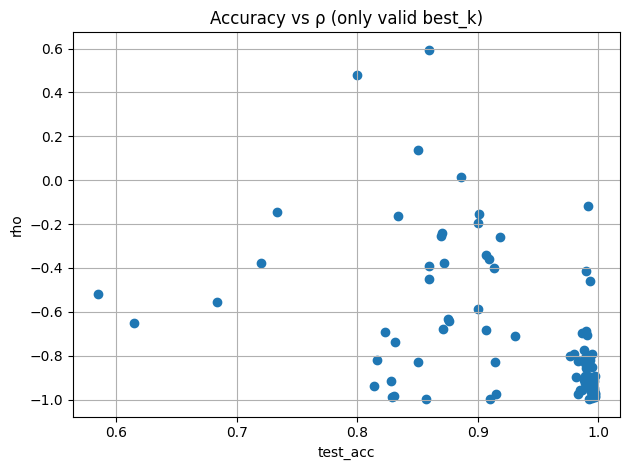

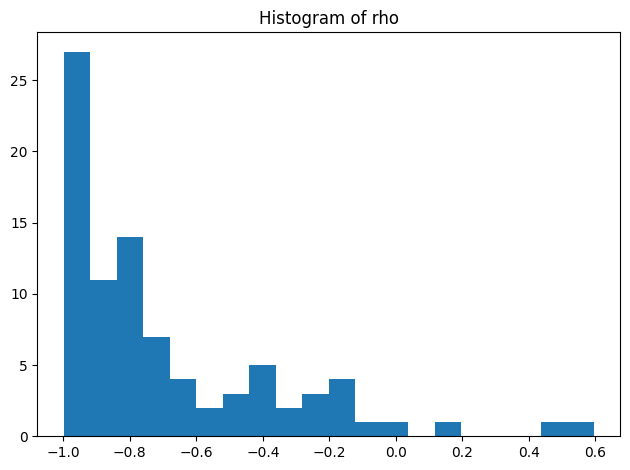

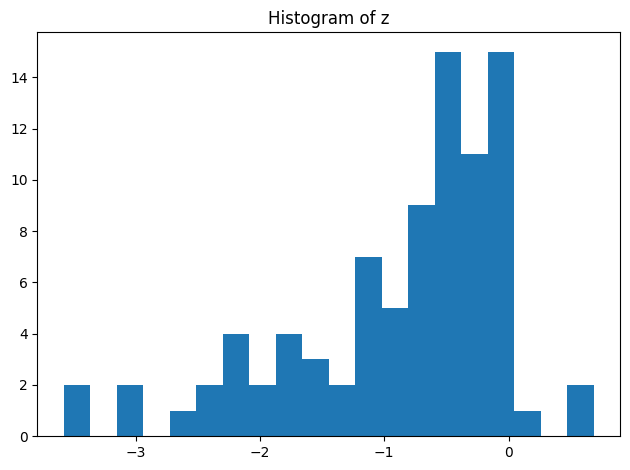

,dataset,width,depth,test_acc,best_k,rho,z,connected_all_layers
0,cifar10_car_v_truck,bottleneck,5,0.635500,NaN,NaN,NaN,False
2,cifar10_car_v_truck,narrow,5,0.691000,NaN,NaN,NaN,False
4,cifar10_car_v_truck,wide,5,0.661000,NaN,NaN,NaN,False
6,cifar10_cat_v_dog,bottleneck,5,0.501000,NaN,NaN,NaN,False
7,cifar10_cat_v_dog,bottleneck,11,0.595500,NaN,NaN,NaN,False
8,cifar10_cat_v_dog,narrow,5,0.500500,NaN,NaN,NaN,False
10,cifar10_cat_v_dog,wide,5,0.500500,NaN,NaN,NaN,False
18,fmnist_shirt_v_coat,bottleneck,5,0.850000,350.0,0.136842,0.137705,True
20,fmnist_shirt_v_coat,narrow,5,0.886000,250.0,0.013625,0.013626,True
26,fmnist_tshirt_v_shirt,narrow,5,0.859500,250.0,0.594197,0.684129,True


Saved artifacts -> /content/report_artifacts


In [ ]:
#@title Report Collector (özet tablo + grafikler) çalıştır
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import json, time, os

ART = Path("report_artifacts"); ART.mkdir(exist_ok=True)

def _safe_read_csv(p):
    try:
        return pd.read_csv(p)
    except Exception:
        return None

# 1) Ana grid özeti
df = _safe_read_csv("ricci_summary.csv")
if df is None or df.empty:
    raise RuntimeError("ricci_summary.csv bulunamadı ya da boş. Grid runner veya tekil koşul çıktısı üretmelisin.")

# 2) Temel temizleme
df["rho_abs"] = df["rho"].abs()
df["ok"] = df["best_k"].notna() & df["rho"].notna() & (df["connected_all_layers"]==True)

# 3) Dataset bazında özet (acc, rho, z ortalama)
g = df.groupby("dataset").agg(
    n=("dataset","size"),
    acc_mean=("test_acc","mean"),
    acc_std=("test_acc","std"),
    rho_mean=("rho","mean"),
    rho_std=("rho","std"),
    z_mean=("z","mean"),
    z_std=("z","std"),
    ok_ratio=("ok","mean")
).reset_index()
g.to_csv(ART/"dataset_summary.csv", index=False)
display(g)

# 4) Mode bazında k ölçeği (senthetic vs real)
kstats = df[df["best_k"].notna()].groupby(["mode","dataset"]).agg(
    k_med=("best_k","median"),
    k_min=("best_k","min"),
    k_max=("best_k","max")
).reset_index()
kstats.to_csv(ART/"kstats_by_dataset.csv", index=False)
display(kstats)

# 5) Scatter: accuracy vs rho   (beklenen: iyi acc -> daha negatif rho)
plt.figure()
ok = df["ok"].fillna(False)
plt.scatter(df.loc[ok,"test_acc"], df.loc[ok,"rho"])
plt.xlabel("test_acc"); plt.ylabel("rho")
plt.title("Accuracy vs ρ (only valid best_k)")
plt.grid(True); plt.tight_layout()
plt.savefig(ART/"scatter_acc_vs_rho.png", dpi=150)
plt.show()

# 6) Histogram: |rho| ve z
for col in ["rho","z"]:
    plt.figure()
    v = df[col].dropna()
    plt.hist(v, bins=20)
    plt.title(f"Histogram of {col}")
    plt.tight_layout()
    plt.savefig(ART/f"hist_{col}.png", dpi=150)
    plt.show()

# 7) Pozitif rho / best=None anomalileri listesi (rapor için)
anom = df[(df["rho"].notna() & (df["rho"]>0)) | df["best_k"].isna()]\
       .sort_values(["dataset","width","depth"])
anom.to_csv(ART/"anomalies.csv", index=False)
display(anom[["dataset","width","depth","test_acc","best_k","rho","z","connected_all_layers"]])

# 8) Küçük JSON özet (rapor şablonu için)
payload = {
    "generated_at": time.ctime(),
    "n_rows": int(len(df)),
    "datasets": sorted(df["dataset"].unique().tolist()),
    "acc_vs_rho_corr": float(df[["test_acc","rho"]].dropna().corr().iloc[0,1]) if df[["test_acc","rho"]].dropna().shape[0]>2 else None
}
json.dump(payload, open(ART/"quick_summary.json","w"), indent=2)
print("Saved artifacts ->", ART.resolve())


In [13]:
#@title MNIST ikili süiti: 4v7, 1v5, 2v6, 6v7 (panel + tablo + CSV)
# Guard: ProgressBoard/timed_step yoksa inline tanımla
try:
    ProgressBoard; timed_step
except NameError:
    from dataclasses import dataclass, field
    from typing import List, Dict, Any, Optional
    import time, pandas as pd, numpy as np
    from IPython.display import clear_output, display
    @dataclass
    class ProgressBoard:
        columns: List[str]
        title: str = "Progress"
        rows: List[Dict[str, Any]] = field(default_factory=list)
        total: Optional[int] = None
        t0: float = field(default_factory=time.time)
        def add(self, **kwargs):
            self.rows.append(kwargs); self.render()
        def render(self):
            clear_output(wait=True)
            df = pd.DataFrame(self.rows)
            for c in self.columns:
                if c not in df.columns: df[c] = np.nan
            df = df[self.columns]
            sort_cols = [c for c in ["dataset","width","depth","elapsed_s"] if c in df.columns]
            if sort_cols: df = df.sort_values(by=sort_cols, na_position='last')
            display(df)
            done = len(self.rows)
            if self.total:
                pct = 100.0 * done / self.total
                elapsed = time.time() - self.t0
                print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {elapsed:.1f}s")
            else:
                print(f"[{self.title}] steps={done} | elapsed {time.time()-self.t0:.1f}s")
    def timed_step(fn, *args, **kwargs):
        t0 = time.time(); out = fn(*args, **kwargs); return out, round(time.time()-t0, 1)

# --- importlar & yardımcılar ---
from pathlib import Path
import numpy as np, pandas as pd, time
from tensorflow.keras.datasets import mnist

DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)

def _subset_digits_flat(x, y, pos, neg):
    sel = np.where((y==pos)|(y==neg))[0]
    X = x[sel].astype('float32')/255.0
    yb = (y[sel]==pos).astype('int64')  # pos sınıf = 1
    X = X.reshape((X.shape[0], -1))     # 28x28 -> 784
    return X, yb

def ensure_mnist_pair(a:int, b:int)->str:
    """mnist_{a}v{b}.npz varsa atla; yoksa oluştur ve kaydet. path döndürür."""
    name = f"mnist_{a}v{b}"
    p = DATA_DIR / f"{name}.npz"
    if p.exists():
        return str(p)
    (Xtr, ytr), (Xte, yte) = mnist.load_data()
    Xtr2, ytr2 = _subset_digits_flat(Xtr, ytr, a, b)
    Xte2, yte2 = _subset_digits_flat(Xte, yte, a, b)
    np.savez_compressed(p, X_train=Xtr2, y_train=ytr2, X_test=Xte2, y_test=yte2)
    print("saved", p, Xtr2.shape, Xte2.shape)
    return str(p)

# --- hedef ikililer ---
PAIRS = [(4,7),(1,5),(2,6),(6,7)]  # istediğini ekleyebilirsin

# --- mimari seti ---
WIDTHS = ["narrow","wide","bottleneck"]
DEPTHS = [5,11]

# --- panel hazırlığı ---
total = len(PAIRS)*len(WIDTHS)*len(DEPTHS)
board = ProgressBoard(
    columns=["dataset","width","depth","test_acc","best_k","rho","z",
             "connected_all_layers","elapsed_s","run_id","error"],
    title="MNIST pair sweep", total=total
)

rows=[]
for (a,b) in PAIRS:
    ds_path = ensure_mnist_pair(a,b)
    ds_name = Path(ds_path).stem
    for w in WIDTHS:
        for d in DEPTHS:
            t0 = time.time()
            try:
                # Train
                (train_out, train_sec) = timed_step(run_one, ds_path, w, d, 60, 128, 0)
                acc, run_id, layer_names = train_out

                # Fast Ricci (MNIST -> sample_size=800)
                ((res, best), sweep_sec) = timed_step(
                    auto_k_sweep_fast, run_id, layer_names, "real", 800, 0.99, 0
                )

                row = dict(
                    dataset=ds_name, width=w, depth=d,
                    test_acc=float(acc),
                    best_k=(int(best[0]) if best else None),
                    rho=(float(best[1]) if best else None) if best else None,
                    z=(float(best[2]) if best else None) if best else None,
                    connected_all_layers=(bool(best[-1]) if best else False) if best else False,
                    elapsed_s=round(time.time()-t0,1),
                    run_id=run_id
                )
                rows.append(row); board.add(**row)
            except Exception as e:
                row = dict(dataset=ds_name, width=w, depth=d, error=str(e),
                           elapsed_s=round(time.time()-t0,1))
                rows.append(row); board.add(**row)

# -- final tablo & kaydet --
df_pairs = pd.DataFrame(rows).sort_values(by=["dataset","width","depth"], na_position='last')
csv_out = Path("ricci_mnist_pairs_summary.csv"); df_pairs.to_csv(csv_out, index=False)
print("Saved ->", csv_out)
df_pairs


,dataset,width,depth,test_acc,best_k,rho,z,connected_all_layers,elapsed_s,run_id,error
10,mnist_1v5,bottleneck,5,0.998520,150,-0.851172,-1.260390,True,52.2,mnist_1v5__bottleneck_d5_seed0,NaN
11,mnist_1v5,bottleneck,11,0.999013,120,-0.943616,-0.669020,True,72.7,mnist_1v5__bottleneck_d11_seed0,NaN
6,mnist_1v5,narrow,5,0.998520,250,-0.753010,-0.979870,True,48.4,mnist_1v5__narrow_d5_seed0,NaN
7,mnist_1v5,narrow,11,0.998520,150,-0.965699,-0.765081,True,71.7,mnist_1v5__narrow_d11_seed0,NaN
8,mnist_1v5,wide,5,0.997040,150,-0.851099,-1.260128,True,49.6,mnist_1v5__wide_d5_seed0,NaN
9,mnist_1v5,wide,11,0.999013,120,-0.985000,-0.923234,True,71.8,mnist_1v5__wide_d11_seed0,NaN
16,mnist_2v6,bottleneck,5,0.994472,350,-0.920478,-1.592149,True,53.3,mnist_2v6__bottleneck_d5_seed0,NaN
17,mnist_2v6,bottleneck,11,0.994472,250,-0.930264,-0.627553,True,73.6,mnist_2v6__bottleneck_d11_seed0,NaN
12,mnist_2v6,narrow,5,0.994975,250,-0.943333,-1.767484,True,47.5,mnist_2v6__narrow_d5_seed0,NaN
13,mnist_2v6,narrow,11,0.994472,150,-0.943037,-0.667033,True,72.0,mnist_2v6__narrow_d11_seed0,NaN


[MNIST pair sweep] 24/24 = 100.0% | elapsed 1470.4s
Saved -> ricci_mnist_pairs_summary.csv


,dataset,width,depth,test_acc,best_k,rho,z,connected_all_layers,elapsed_s,run_id
10,mnist_1v5,bottleneck,5,0.998520,150,-0.851172,-1.260390,True,52.2,mnist_1v5__bottleneck_d5_seed0
11,mnist_1v5,bottleneck,11,0.999013,120,-0.943616,-0.669020,True,72.7,mnist_1v5__bottleneck_d11_seed0
6,mnist_1v5,narrow,5,0.998520,250,-0.753010,-0.979870,True,48.4,mnist_1v5__narrow_d5_seed0
7,mnist_1v5,narrow,11,0.998520,150,-0.965699,-0.765081,True,71.7,mnist_1v5__narrow_d11_seed0
8,mnist_1v5,wide,5,0.997040,150,-0.851099,-1.260128,True,49.6,mnist_1v5__wide_d5_seed0
9,mnist_1v5,wide,11,0.999013,120,-0.985000,-0.923234,True,71.8,mnist_1v5__wide_d11_seed0
16,mnist_2v6,bottleneck,5,0.994472,350,-0.920478,-1.592149,True,53.3,mnist_2v6__bottleneck_d5_seed0
17,mnist_2v6,bottleneck,11,0.994472,250,-0.930264,-0.627553,True,73.6,mnist_2v6__bottleneck_d11_seed0
12,mnist_2v6,narrow,5,0.994975,250,-0.943333,-1.767484,True,47.5,mnist_2v6__narrow_d5_seed0
13,mnist_2v6,narrow,11,0.994472,150,-0.943037,-0.667033,True,72.0,mnist_2v6__narrow_d11_seed0


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
#@title MLP-Arch + OPT/LR/LOSS destekli run_one_arch_opt (Keras 3 uyumlu) çalıştır
# Guard: ProgressBoard yoksa inline tanımla
try:
    ProgressBoard; timed_step
except NameError:
    from dataclasses import dataclass, field
    from typing import List, Dict, Any, Optional
    import time, pandas as pd, numpy as np
    from IPython.display import clear_output, display
    @dataclass
    class ProgressBoard:
        columns: List[str]; title: str = "Progress"
        rows: List[Dict[str, Any]] = field(default_factory=list)
        total: Optional[int] = None; t0: float = field(default_factory=time.time)
        def add(self, **kwargs): self.rows.append(kwargs); self.render()
        def render(self):
            clear_output(wait=True)
            df = pd.DataFrame(self.rows)
            for c in self.columns:
                if c not in df.columns: df[c] = np.nan
            df = df[self.columns]
            sort_cols = [c for c in ["dataset","width","depth","elapsed_s"] if c in df.columns]
            if sort_cols: df = df.sort_values(by=sort_cols, na_position='last')
            display(df)
            done = len(self.rows)
            if self.total:
                pct = 100.0 * done / self.total; elapsed = time.time()-self.t0
                print(f"[{self.title}] {done}/{self.total} = {pct:.1f}% | elapsed {elapsed:.1f}s")
            else:
                print(f"[{self.title}] steps={done} | elapsed {time.time()-self.t0:.1f}s")
    def timed_step(fn, *args, **kwargs):
        t0=time.time(); out=fn(*args, **kwargs); return out, round(time.time()-t0,1)

from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

EMB_DIR = Path("embeddings"); EMB_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR = Path("checkpoints"); CKPT_DIR.mkdir(parents=True, exist_ok=True)

def get_activation_layer(name: str):
    name = name.lower()
    if name=="relu":  return layers.ReLU()
    if name=="gelu":  return layers.Activation(tf.keras.activations.gelu)
    if name in ("silu","swish"): return layers.Activation(tf.keras.activations.silu)
    if name=="tanh":  return layers.Activation("tanh")
    if name=="leakyrelu": return layers.LeakyReLU(alpha=0.1)
    if name=="elu":   return layers.ELU(alpha=1.0)
    raise ValueError(f"Unsupported activation: {name}")

def get_optimizer(name: str, lr: float):
    name = name.lower()
    if name=="rmsprop": return keras.optimizers.RMSprop(learning_rate=lr)
    if name=="adam":    return keras.optimizers.Adam(learning_rate=lr)
    if name=="adamw":   return keras.optimizers.AdamW(learning_rate=lr, weight_decay=1e-4)
    if name=="sgd":     return keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True)
    raise ValueError(f"Unsupported optimizer: {name}")

def focal_loss(alpha=0.25, gamma=2.0, label_smoothing=0.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        if label_smoothing>0:
            y_true = y_true*(1-label_smoothing) + 0.5*label_smoothing
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred, eps, 1-eps)
        p_t = y_true*y_pred + (1-y_true)*(1-y_pred)
        alpha_t = y_true*alpha + (1-y_true)*(1-alpha)
        return tf.reduce_mean(-alpha_t * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t))
    return loss

def make_hinge_loss(squared=False):
    # Bizim etiketler 0/1; hinge {-1,+1} ister. Dönüştürüyoruz.
    def loss(y_true, y_pred):
        y = tf.cast(y_true, tf.float32)*2.0 - 1.0
        s = (y_pred*2.0 - 1.0)  # sigmoid çıktı -> skora dönüştür
        m = 1.0 - y*s
        if squared:
            m = tf.square(tf.maximum(0.0, m))
        else:
            m = tf.maximum(0.0, m)
        return tf.reduce_mean(m)
    return loss

def get_loss(name: str):
    name = name.lower()
    if name in ("bce","binary_crossentropy"): return "binary_crossentropy"
    if name=="focal": return focal_loss(alpha=0.25, gamma=2.0)
    if name=="hinge": return make_hinge_loss(squared=False)
    if name in ("squared_hinge","hinge2"): return make_hinge_loss(squared=True)
    raise ValueError(f"Unsupported loss: {name}")

def _sanitize(s: str) -> str:
    return s.replace("/","_").replace("\\","_").replace(" ","_")

def build_mlp_arch(input_dim, width="narrow", depth=5,
                   activation="relu", batchnorm=False, dropout=0.0, residual=False):
    assert width in ["narrow","wide","bottleneck"]
    if residual and width=="bottleneck":
        residual=False  # boyut değişimi nedeniyle güvenli değil

    inputs = keras.Input(shape=(input_dim,))
    x = inputs; taps=[]; names=[]

    def block(x, units, i):
        z = layers.Dense(units, use_bias=(not batchnorm), name=f"dense_{i}_{units}")(x)
        if batchnorm: z = layers.BatchNormalization(name=f"bn_{i}")(z)
        z = get_activation_layer(activation)(z)
        if dropout and dropout>0: z = layers.Dropout(dropout, name=f"drop_{i}")(z)
        if residual and (x.shape[-1]==units):
            z = layers.Add(name=f"res_{i}")([x, z])
        taps.append(z); names.append(f"block{i}_{units}_{activation}{'_bn' if batchnorm else ''}{f'_do{dropout}' if dropout else ''}{'_res' if residual else ''}")
        return z

    if width=="bottleneck":
        units_list = [50,50,25,50,50] if depth==5 else [50,50,50,50,50,25,50,50,50,50,50]
    else:
        units_list = [25 if width=="narrow" else 50]*depth

    for i,u in enumerate(units_list,1): x = block(x,u,i)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)
    model = keras.Model(inputs, out)
    inter = keras.Model(inputs, taps)
    return model, inter, names

def run_one_arch_opt(dataset_npz, width, depth,
                     activation="relu", batchnorm=False, dropout=0.0, residual=False,
                     optimizer="rmsprop", lr=1e-3, loss="bce",
                     epochs=60, batch_size=128, seed=0):
    d = np.load(dataset_npz)
    Xtr,ytr,Xte,yte = d['X_train'], d['y_train'], d['X_test'], d['y_test']
    tf.keras.utils.set_random_seed(seed)

    model, inter, layer_names = build_mlp_arch(
        Xtr.shape[1], width, depth, activation, batchnorm, dropout, residual
    )
    opt  = get_optimizer(optimizer, lr)
    los  = get_loss(loss)
    model.compile(optimizer=opt, loss=los, metrics=["accuracy"])

    _ = model.fit(Xtr, ytr, validation_data=(Xte, yte), epochs=epochs, batch_size=batch_size, verbose=0)
    te_loss, te_acc = model.evaluate(Xte, yte, verbose=0)
    emb_list = inter.predict(Xte, batch_size=1024, verbose=0)

    base = (
        Path(dataset_npz).stem
        + f"__{width}_d{depth}_act{activation}"
        + (f"_bn" if batchnorm else "")
        + (f"_do{dropout}" if dropout else "")
        + (f"_res" if residual else "")
        + f"__opt{optimizer}_lr{lr:g}_loss{loss}"
        + f"_seed{seed}"
    )
    out_dir = EMB_DIR / base; out_dir.mkdir(parents=True, exist_ok=True)
    for name, E in zip(layer_names, emb_list):
        np.save(out_dir / f"{_sanitize(name)}.npy", E)
    model.save(CKPT_DIR / f"{base}.keras")
    np.save(out_dir/"y_test.npy", yte); np.save(out_dir/"X_test.npy", Xte)
    return float(te_acc), base, layer_names


In [ ]:
#@title Training Config Sweep: OPT/LR/LOSS + ACT/BN/DO/RES (panel + CSV)
from pathlib import Path
import numpy as np, pandas as pd, time

DATASETS = [
  ("data/synthetic_A_moons_1k_each.npz","synthetic"),
  ("data/mnist_1v7.npz","real"),
  ("data/fmnist_sandal_v_boot.npz","real"),
  ("data/cifar10_car_v_truck.npz","real"),
  ("data/svhn_1v7.npz","real"),
]

WIDTHS = ["narrow","wide"]
DEPTHS = [5,11]
ACTS   = ["relu","gelu","silu"]          # istersen "tanh" ekle
BNS    = [False, True]
DROPS  = [0.0, 0.2]
RESID  = [False]

OPTS   = ["rmsprop","adam"]              # istersen "adamw","sgd" ekle
LRS    = [1e-3, 3e-4]                    # istersen [1e-3,5e-4,1e-4]
LOSSES = ["bce","focal"]                 # istersen "hinge","squared_hinge" ekle

def _sample_size_for(mode, ds_name):
    if mode=='synthetic': return None
    return 1200 if ds_name.startswith(("cifar10","svhn")) else 800

total = (len(DATASETS)*len(WIDTHS)*len(DEPTHS)*len(ACTS)*
         len(BNS)*len(DROPS)*len(RESID)*len(OPTS)*len(LRS)*len(LOSSES))
board = ProgressBoard(
    columns=["dataset","mode","width","depth","act","bn","drop","res",
             "opt","lr","loss","test_acc","best_k","rho","z",
             "connected_all_layers","elapsed_s","run_id","error"],
    title="Training Config Sweep", total=total
)

rows=[]
for (ds, mode) in DATASETS:
    ds_name = Path(ds).stem
    for w in WIDTHS:
        for d in DEPTHS:
            for act in ACTS:
                for bn in BNS:
                    for dr in DROPS:
                        for rs in RESID:
                            for opt in OPTS:
                                for lr in LRS:
                                    for loss in LOSSES:
                                        t0=time.time()
                                        try:
                                            # Train + embed
                                            (train_out, train_secs) = timed_step(
                                                run_one_arch_opt, ds, w, d,
                                                act, bn, dr, rs,
                                                opt, lr, loss,
                                                60, 128, 0
                                            )
                                            acc, run_id, lns = train_out
                                            # k-sweep
                                            ss = _sample_size_for(mode, ds_name)
                                            ((res, best), sweep_secs) = timed_step(
                                                auto_k_sweep_fast, run_id, lns, mode, ss, 0.99, 0
                                            )
                                            row = dict(
                                                dataset=ds_name, mode=mode, width=w, depth=d,
                                                act=act, bn=bn, drop=dr, res=rs,
                                                opt=opt, lr=lr, loss=loss,
                                                test_acc=float(acc),
                                                best_k=(int(best[0]) if best else None),
                                                rho=(float(best[1]) if best else None) if best else None,
                                                z=(float(best[2]) if best else None) if best else None,
                                                connected_all_layers=(bool(best[-1]) if best else False) if best else False,
                                                elapsed_s=round(time.time()-t0,1), run_id=run_id
                                            )
                                            rows.append(row); board.add(**row)
                                        except Exception as e:
                                            row = dict(dataset=ds_name, mode=mode, width=w, depth=d,
                                                       act=act, bn=bn, drop=dr, res=rs,
                                                       opt=opt, lr=lr, loss=loss,
                                                       error=str(e), elapsed_s=round(time.time()-t0,1))
                                            rows.append(row); board.add(**row)

df_cfg = pd.DataFrame(rows).sort_values(
    by=["dataset","width","depth","act","bn","drop","res","opt","lr","loss"],
    na_position='last'
)
out_csv = Path("ricci_training_config_sweep.csv"); df_cfg.to_csv(out_csv, index=False)
print("Saved ->", out_csv)
df_cfg


,dataset,mode,width,depth,act,bn,drop,res,opt,lr,loss,test_acc,best_k,rho,z,connected_all_layers,elapsed_s,run_id,error
419,mnist_1v7,real,narrow,5,gelu,False,0.0,False,rmsprop,0.0003,focal,0.995377,120.0,-0.984084,-2.412808,True,42.5,mnist_1v7__narrow_d5_actgelu__optrmsprop_lr0.0...,NaN
418,mnist_1v7,real,narrow,5,gelu,False,0.0,False,rmsprop,0.0003,bce,0.994914,350.0,-1.000000,-8.048120,True,42.6,mnist_1v7__narrow_d5_actgelu__optrmsprop_lr0.0...,NaN
416,mnist_1v7,real,narrow,5,gelu,False,0.0,False,rmsprop,0.0010,bce,0.996764,350.0,-0.999463,-4.111348,True,42.7,mnist_1v7__narrow_d5_actgelu__optrmsprop_lr0.0...,NaN
417,mnist_1v7,real,narrow,5,gelu,False,0.0,False,rmsprop,0.0010,focal,0.995839,350.0,-0.979135,-2.276170,True,42.7,mnist_1v7__narrow_d5_actgelu__optrmsprop_lr0.0...,NaN
385,mnist_1v7,real,narrow,5,relu,False,0.0,False,rmsprop,0.0010,focal,0.995377,120.0,-0.953199,-1.865659,True,43.0,mnist_1v7__narrow_d5_actrelu__optrmsprop_lr0.0...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,synthetic_A_moons_1k_each,synthetic,wide,11,silu,True,0.0,False,adam,0.0003,focal,0.712000,90.0,-0.086039,-0.035213,True,63.1,synthetic_A_moons_1k_each__wide_d11_actsilu_bn...,NaN
350,synthetic_A_moons_1k_each,synthetic,wide,11,gelu,True,0.2,False,adam,0.0003,bce,0.901000,10.0,-0.924046,-0.659740,True,63.4,synthetic_A_moons_1k_each__wide_d11_actgelu_bn...,NaN
349,synthetic_A_moons_1k_each,synthetic,wide,11,gelu,True,0.2,False,adam,0.0010,focal,0.852000,9.0,-0.838293,-0.496186,True,63.5,synthetic_A_moons_1k_each__wide_d11_actgelu_bn...,NaN
332,synthetic_A_moons_1k_each,synthetic,wide,11,gelu,False,0.2,False,adam,0.0010,bce,0.904000,9.0,-0.446870,-0.196279,True,63.7,synthetic_A_moons_1k_each__wide_d11_actgelu_do...,NaN


[Training Config Sweep] 445/1920 = 23.2% | elapsed 18213.9s
